In [38]:
import os

import torch
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import torchvision.transforms.v2 as T
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import transforms

import matplotlib.pyplot as plt
from itertools import cycle

from tqdm.notebook import tqdm

import random
import numpy as np

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [40]:
COCO_PATH = "./data/coco/"  # change this
IMG_DIR_TRAIN = os.path.join(COCO_PATH, "images/train2017")
IMG_DIR_VAL = os.path.join(COCO_PATH, "images/val2017")
ANN_FILE_TRAIN = os.path.join(COCO_PATH, "annotations/person_keypoints_train2017.json")
ANN_FILE_VAL = os.path.join(COCO_PATH, "annotations/person_keypoints_val2017.json")

NUM_KEYPOINTS = 17
MAX_PERSONS = 2

# Data

In [41]:
class CustomTransform:
    def __init__(self, size=(256, 256)):
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor()
        ])
    
    def __call__(self, image, target):
        return self.transform(image), target
    

In [42]:
class CocoKeypointsDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self.coco = COCO(ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        orig_w, orig_h = img.size  # PIL image size (width, height)
        ann_ids = self.coco.getAnnIds(imgIds=self.ids[idx], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        # Filter for annotations with keypoints
        anns = [ann for ann in anns if 'keypoints' in ann]
        target = {
            "image_id": self.ids[idx],
            "annotations": anns,
            "orig_size": (orig_w, orig_h)
        }
        if self._transforms:
            img, target = self._transforms(img, target)
        return img, target
    

In [43]:
def coco_collate_fn(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack([img for img in imgs])
    keypoints = []
    for i, t in enumerate(targets):
        anns = t['annotations']
        orig_w, orig_h = t['orig_size']
        kp_list = []
        for ann in anns[:MAX_PERSONS]:
            kp = torch.tensor(ann['keypoints']).view(NUM_KEYPOINTS, 3).float()  # (17,3)
            # Scale x, y to match resized image (256, 256)
            kp[:, 0] = kp[:, 0] * (256.0 / orig_w)
            kp[:, 1] = kp[:, 1] * (256.0 / orig_h)
            kp_list.append(kp)
        # Pad with zeros if fewer than MAX_PERSONS
        while len(kp_list) < MAX_PERSONS:
            kp_list.append(torch.zeros(NUM_KEYPOINTS, 3))
        kp_stack = torch.stack(kp_list)  # (MAX_PERSONS, 17, 3)
        keypoints.append(kp_stack)
    keypoints = torch.stack(keypoints)  # (batch, MAX_PERSONS, 17, 3)
    return imgs, keypoints

In [44]:
train_dataset = CocoKeypointsDataset(IMG_DIR_TRAIN, ANN_FILE_TRAIN, transforms=CustomTransform())
val_dataset = CocoKeypointsDataset(IMG_DIR_VAL, ANN_FILE_VAL, transforms=CustomTransform())

val_size = int(0.5 * len(val_dataset))
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])


loading annotations into memory...
Done (t=6.49s)
creating index...
Done (t=6.49s)
creating index...
index created!
loading annotations into memory...
index created!
loading annotations into memory...
Done (t=7.18s)
creating index...
Done (t=7.18s)
creating index...
index created!
loading annotations into memory...
index created!
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Done (t=0.23s)
creating index...
index created!


In [45]:
print("train dataset size:", len(train_dataset))
print("val dataset size:", len(val_dataset))
print("test dataset size:", len(test_dataset))

train dataset size: 118287
val dataset size: 2500
test dataset size: 2500


In [46]:
subset_len_train = int(0.01 * len(train_dataset))
subset_len_val = int(0.1 * len(val_dataset))
subset_len_test = int(0.1 * len(test_dataset))

train_dataset = torch.utils.data.Subset(train_dataset, range(subset_len_train))
val_dataset = torch.utils.data.Subset(val_dataset, range(subset_len_val))
test_dataset = torch.utils.data.Subset(test_dataset, range(subset_len_test))

In [47]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=coco_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=coco_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=coco_collate_fn)

In [48]:
print("train dataset size:", len(train_dataset))
print("val dataset size:", len(val_dataset))
print("test dataset size:", len(test_dataset))

train dataset size: 1182
val dataset size: 250
test dataset size: 250


## Visualize data

In [49]:
def visualize_prediction(img_tensor, keypoints_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    colors = cycle(plt.cm.tab10.colors)
    # Plot GT keypoints for all persons
    for i, kp in enumerate(keypoints_tensor):
        kp = kp.cpu().numpy()
        if np.all(kp == 0):
            continue
        color = next(colors)
        plt.scatter(kp[:, 0], kp[:, 1], color=color, label=f'GT {i+1}')
    plt.legend()
    plt.show()

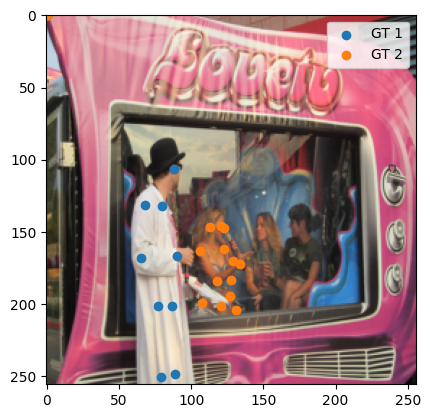

Person 1 keypoints:
tensor([[  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [ 88.4000, 106.6667,   2.0000],
        [ 80.0000, 131.7333,   2.0000],
        [ 68.0000, 131.2000,   2.0000],
        [  0.0000,   0.0000,   0.0000],
        [ 65.2000, 168.0000,   2.0000],
        [  0.0000,   0.0000,   0.0000],
        [ 90.4000, 166.4000,   2.0000],
        [ 86.4000, 201.0667,   2.0000],
        [ 76.8000, 201.6000,   2.0000],
        [ 88.8000, 248.5333,   2.0000],
        [ 79.2000, 250.1333,   2.0000],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000]])
Person 2 keypoints:
tensor([[122.4000, 147.2000,   2.0000],
        [  0.0000,   0.0000,   0.0000],
        [120.8000, 145.6000,   2.0000],
        [  0.0000,   0.0000,   0.0000],
        [113.2000, 146.6667,   2.0000],
        [122.4000, 161.6000,   2.0000],
        [106.0000, 163.2000,   2.0000],

In [50]:
imgs, targets = next(iter(test_loader))

if 'test_iter' not in globals():
    test_iter = iter(test_loader)
try:
    imgs, targets = next(test_iter)
except StopIteration:
    test_iter = iter(test_loader)
    imgs, targets = next(test_iter)

imgs = imgs.to(device)


idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
keypoints = targets[idx]  # (MAX_PERSONS, 17, 3)

visualize_prediction(img, keypoints)


for i, kp in enumerate(keypoints):
    print(f"Person {i+1} keypoints:\n{kp}")

# Model

In [51]:
class KeypointModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet18(pretrained=True)
        # Output: (batch, MAX_PERSONS * NUM_KEYPOINTS * 3)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, MAX_PERSONS * NUM_KEYPOINTS * 3)

    def forward(self, x):
        x = self.backbone(x)
        # Reshape to (batch, MAX_PERSONS, NUM_KEYPOINTS, 3)
        x = x.view(x.size(0), MAX_PERSONS, NUM_KEYPOINTS, 3)
        return x

In [52]:
# class KeypointModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             # Output: (MAX_PERSONS, NUM_KEYPOINTS, 3) where 3 = (x, y, visibility)
#             nn.Linear(4096, MAX_PERSONS * NUM_KEYPOINTS * 3),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         x = x.view(x.size(0), MAX_PERSONS, NUM_KEYPOINTS, 3)
#         return x

In [53]:
def train_one_epoch(model, dataloader, optimizer, criterion, use_tqdm=False):
    model.train()
    total_loss = 0

    enumerator = tqdm(dataloader) if use_tqdm else dataloader
    for imgs, keypoints in enumerator:
        imgs = imgs.to(device)
        keypoints = keypoints.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [54]:
def evaluate(model, dataloader):
    model.eval()
    preds_list, gt_list = [], []
    with torch.no_grad():
        for imgs, keypoints in dataloader:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)
            preds = model(imgs)
            preds_list.append(preds.cpu())
            gt_list.append(keypoints.cpu())
    # Concatenate all batches
    preds_all = torch.cat(preds_list, dim=0)
    gt_all = torch.cat(gt_list, dim=0)
    return preds_all, gt_all

# Train

In [61]:
EPOCHS = 100


In [62]:
model = KeypointModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_losses = []
val_losses = []

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)

    preds_all, gt_all = evaluate(model, val_loader)
    val_loss = criterion(preds_all, gt_all).item()
    val_losses.append(val_loss)

    # print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

# Visualize

In [ ]:
def visualize_prediction(img_tensor, keypoints_tensor, pred_keypoints_tensor=None):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    colors = cycle(plt.cm.tab10.colors)
    # Plot GT keypoints for all persons
    for i, kp in enumerate(keypoints_tensor):
        kp = kp.cpu().numpy()
        if np.all(kp == 0):
            continue
        color = next(colors)
        plt.scatter(kp[:, 0], kp[:, 1], color=color, label=f'GT {i+1}')
    # Plot predicted keypoints for all persons
    if pred_keypoints_tensor is not None:
        colors_pred = cycle(plt.cm.Dark2.colors)
        for i, pk in enumerate(pred_keypoints_tensor):
            pk = pk.cpu().numpy()
            if np.all(pk == 0):
                continue
            color = next(colors_pred)
            plt.scatter(pk[:, 0], pk[:, 1], color=color, marker='x', label=f'Pred {i+1}')
    plt.legend()
    plt.show()

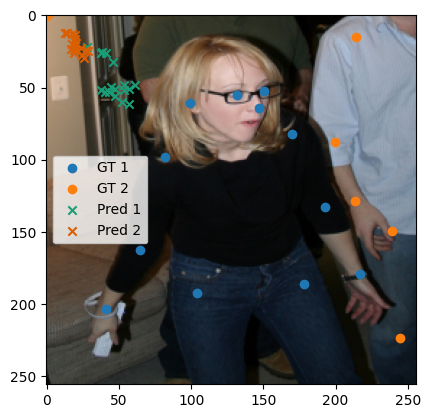

Person 1 keypoints:
tensor([[ 4.5540e+01,  3.2501e+01,  7.0361e-01],
        [ 4.0950e+01,  2.6251e+01,  6.2912e-01],
        [ 3.7233e+01,  2.6132e+01,  2.8525e-01],
        [ 3.7917e+01,  2.5555e+01,  1.2374e+00],
        [ 2.8015e+01,  2.1802e+01, -3.6328e-02],
        [ 6.0878e+01,  4.8215e+01,  1.0833e+00],
        [ 5.3391e+01,  4.8432e+01,  1.1356e+00],
        [ 5.6737e+01,  5.0942e+01,  1.0059e+00],
        [ 4.7138e+01,  5.0743e+01,  8.1856e-01],
        [ 5.3516e+01,  5.1465e+01,  9.1722e-01],
        [ 4.4322e+01,  4.9315e+01,  6.0185e-01],
        [ 5.6593e+01,  6.1082e+01,  9.6624e-01],
        [ 5.1901e+01,  6.0317e+01,  1.1119e+00],
        [ 4.7114e+01,  5.6027e+01,  7.5987e-01],
        [ 4.3123e+01,  5.2866e+01,  8.3013e-01],
        [ 3.9995e+01,  5.2831e+01,  5.2992e-01],
        [ 3.7823e+01,  5.1919e+01,  6.8934e-01]])
Person 2 keypoints:
tensor([[1.9592e+01, 1.6328e+01, 8.0756e-02],
        [1.7170e+01, 1.3174e+01, 1.0052e-01],
        [1.4071e+01, 1.2005e+01, 2

In [ ]:
imgs, targets = next(iter(test_loader))
imgs = imgs.to(device)
with torch.no_grad():
    preds = model(imgs)

idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
gt_kpts_list = targets[idx]  # (MAX_PERSONS, 17, 3)
pred_kpts_list = preds[idx].cpu()  # (MAX_PERSONS, 17, 3)

visualize_prediction(img, gt_kpts_list, pred_kpts_list)

for i, kp in enumerate(pred_kpts_list):
    print(f"Person {i+1} keypoints:\n{kp}")

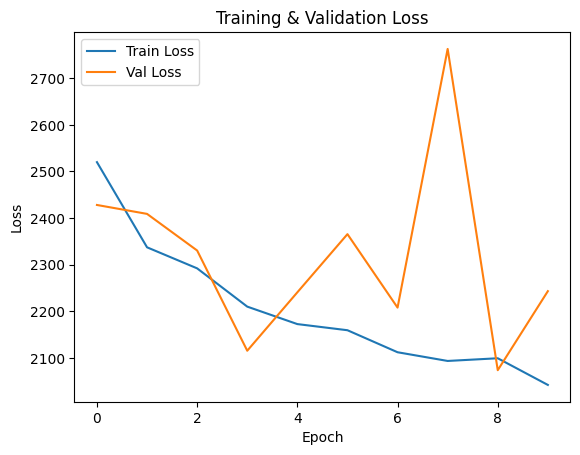

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()